# IRTM Project 
#### _Inkheart trilogy_ - **Abel de Wit**
---

## Data Loading
Import all the necessary modules for this project

In [247]:
import re
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.corpus import stopwords
from collections import defaultdict, Counter

from main_functions import *
from ast import literal_eval

import spacy
import neuralcoref
import itertools
import random

Read in the data, if a dataFrame.csv has been created, this can be skipped and it can be read later

In [248]:
book_1, book_2, book_3 = read_data()

In [254]:
import pandas as pd
import itertools as it
import tqdm
from tqdm import tqdm_notebook

tqdm_notebook().pandas()

idx1 = [('book_1', f'ch_{c}') for c in range(len(book_1))]
idx2 = [('book_2', f'ch_{c}') for c in range(len(book_2))]
idx3 = [('book_3', f'ch_{c}') for c in range(len(book_3))]
idx1.extend(idx2)
idx1.extend(idx3)
idx = pd.MultiIndex.from_tuples(idx1, names=['book', 'chapter'])


df = pd.DataFrame(index=idx)

full_1 = [' '.join(sentences) for sentences in book_1.values()]
full_2 = [' '.join(sentences) for sentences in book_2.values()]
full_3 = [' '.join(sentences) for sentences in book_3.values()]

df['text'] = [text.replace('Mortimer', 'Mo') for text in list(it.chain(full_1, full_2, full_3))]

identity = str.maketrans("", "", '()')
# Split the text into sentences using sent_tokenize
df['sentences'] = df['text'].progress_apply(lambda x: nltk.sent_tokenize(x.translate(identity)))
# Split the sentences into tokens using word_tokenize
df['tokens'] = df['sentences'].progress_apply(lambda x: [nltk.word_tokenize(sent) for sent in x])
# Give each token a pos tag
df['pos'] = df['tokens'].progress_apply(lambda x: [nltk.pos_tag(sent) for sent in x])

# Create both an 'unspecific' and 'specific' tree for the named entity recoginition
df['binary_tree'] = df['pos'].progress_apply(lambda x: [str(tree) for tree in nltk.ne_chunk_sents(x, binary=True)])
df['tree'] = df['pos'].progress_apply(lambda x: [str(tree) for tree in nltk.ne_chunk_sents(x)])

<ipython-input-254-b9bb08269803>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

In [255]:
def extract_person(tree, _entityNames = None):
    """
    Loopts trough the nltk tree so find PERSON's
    returns a list of entity names
    """
    try:
        if _entityNames is None:
            _entityNames = []

        try:
            label = tree.label()
        except AttributeError:
            pass
        else:
            if label == 'PERSON':
                # print(label, tree[0].split('/')[0])
                _entityNames.append(tree[0].split('/')[0])
            else:
                for child in tree:
                    extract_person(child, _entityNames)
    except ValueError:
        print(tree)
    return _entityNames

def extract_chap_person(sent_list):
    e_names = []
    for sent in sent_list:
        tree = nltk.Tree.fromstring(sent)
        e_names.append(extract_person(tree))

    return removeStopwords(e_names)

def removeStopwords(entityNames, customStopWords=None):
    """
    The nltk pos tagger has some difficulties with standard English words
    that are at the beginning of a sentence 
    (e.g. "Try that new shampoo" -> ('Try', NE))
    Hence, we remove stopwords from the possible character list, 
    the stopwords are extended with custom words that were added manually
    """
    filterNames = []
    if customStopWords is None:
        with open("./customStopWords.txt", "r") as f:
            customStopWords = f.read().split(', ')

    for name in entityNames:
        if (name not in stopwords.words('english')) and (name not in customStopWords):
            filterNames.append(name)

    return filterNames

# Create a new column for the named entities
df['named_entities'] = df['tree'].progress_apply(lambda x: extract_chap_person(x))
    

  0%|          | 0/219 [00:00<?, ?it/s]

In [275]:
df.head()

text  \
book   chapter                                                      
book_1 ch_0     Rain fell that night, a fine, whispering rain....   
       ch_1     It was early dawn when Meggie woke up. Night w...   
       ch_2     Dustfinger must have been waiting in the road ...   
       ch_3     Meggie woke up because it was so quiet. The re...   
       ch_4     They had unwrapped the book. Meggie saw the br...   

                                                        sentences  \
book   chapter                                                      
book_1 ch_0     [Rain fell that night, a fine, whispering rain...   
       ch_1     [It was early dawn when Meggie woke up., Night...   
       ch_2     [Dustfinger must have been waiting in the road...   
       ch_3     [Meggie woke up because it was so quiet., The ...   
       ch_4     [They had unwrapped the book., Meggie saw the ...   

                                                           tokens  \
book   chapter                                                      
book_1 ch_0     [[Rain, fell, that, night, ,, a, fine, ,, whis...   
       ch_1     [[It, was, early, dawn, when, Meggie, woke, up...   
       ch_2     [[Dustfinger, must, have, been, waiting, in, t...   
       ch_3     [[Meggie, woke, up, because, it, was, so, quie...   
       ch_4     [[They, had, unwrapped, the, book, .], [Meggie...   

                                                              pos  \
book   chapter                                                      
book_1 ch_0     [[(Rain, NN), (fell, VBD), (that, IN), (night,...   
       ch_1     [[(It, PRP), (was, VBD), (early, JJ), (dawn, N...   
       ch_2     [[(Dustfinger, NNP), (must, MD), (have, VB), (...   
       ch_3     [[(Meggie, NNP), (woke, VBD), (up, RP), (becau...   
       ch_4     [[(They, PRP), (had, VBD), (unwrapped, VBN), (...   

                                                      binary_tree  \
book   chapter                                                      
book_1 ch_0     [(S\n  (NE Rain/NN)\n  fell/VBD\n  that/IN\n  ...   
       ch_1     [(S\n  It/PRP\n  was/VBD\n  early/JJ\n  dawn/N...   
       ch_2     [(S\n  (NE Dustfinger/NNP)\n  must/MD\n  have/...   
       ch_3     [(S\n  (NE Meggie/NNP)\n  woke/VBD\n  up/RP\n ...   
       ch_4     [(S They/PRP had/VBD unwrapped/VBN the/DT book...   

                                                             tree  \
book   chapter                                                      
book_1 ch_0     [(S\n  (GPE Rain/NN)\n  fell/VBD\n  that/IN\n ...   
       ch_1     [(S\n  It/PRP\n  was/VBD\n  early/JJ\n  dawn/N...   
       ch_2     [(S\n  (PERSON Dustfinger/NNP)\n  must/MD\n  h...   
       ch_3     [(S\n  (PERSON Meggie/NNP)\n  woke/VBD\n  up/R...   
       ch_4     [(S They/PRP had/VBD unwrapped/VBN the/DT book...   

                                                   named_entities  \
book   chapter                                                      
book_1 ch_0     [[], [Meggie], [Meggie], [], [], [], [Meggie],...   
       ch_1     [[Meggie], [], [Meggie], [], [], [], [], [Megg...   
       ch_2     [[Dustfinger], [Meggie], [Dustfinger, Meggie],...   
       ch_3     [[Meggie], [], [], [Meggie], [], [], [Meggie],...   
       ch_4     [[], [Meggie], [Elinor], [], [], [Elinor], [],...   

                                                         ne_count  \
book   chapter                                                      
book_1 ch_0            {'Meggie': 42, 'Mo': 14, 'Dustfinger': 13}   
       ch_1                              {'Meggie': 37, 'Mo': 18}   
       ch_2     {'Dustfinger': 30, 'Meggie': 30, 'Mo': 11, 'Ca...   
       ch_3     {'Meggie': 67, 'Dustfinger': 16, 'Elinor': 31,...   
       ch_4     {'Meggie': 55, 'Elinor': 20, 'Mo': 15, 'Dustfi...   

                                                              doc  \
book   chapter                                                      
book_1 ch_0     (Rain, fell, that, night, ,, a, fin

In [256]:
def count_dict(ne_list):
    """
    Counts how often a named entity occurs in a chapter
    returns a dictionary with the names as keys and the occurrences as values
    """
    counter = {}
    for ne in itertools.chain(ne_list):
        for name in ne:
            if name in counter.keys():
                counter[name] += 1
            else:
                counter[name] = 1
    # Remove occurrences less than 2, usually these are misfires
    return {key: value for key, value in counter.items() if value > 2}

df['ne_count'] = df['named_entities'].progress_apply(count_dict)

  0%|          | 0/219 [00:00<?, ?it/s]

In [ ]:
# Save the dataframe
df.to_csv('./dataFrame.csv')

If the dataFrame.csv has been provided, it can be read here without running the cells above

In [ ]:
# Read the saved dataframe
cols = list(df.columns)
conv = dict.fromkeys(cols[1:], literal_eval)
df = pd.read_csv('./dataFrame.csv', index_col=[0,1], converters=conv)
df.head(2)

## Character extraction & visualisation
 Now it's time to process the data and get some information retrieval going

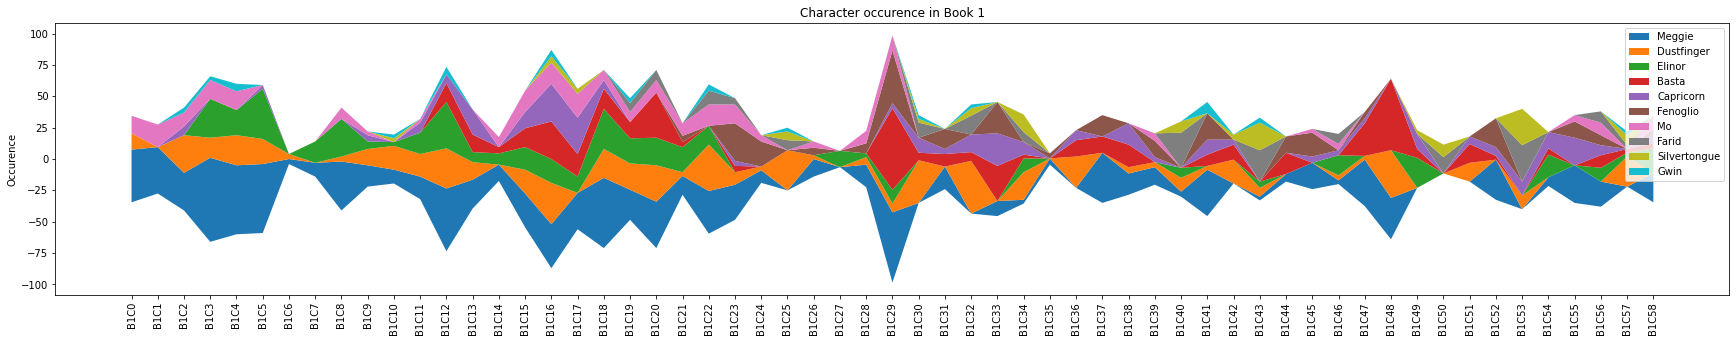

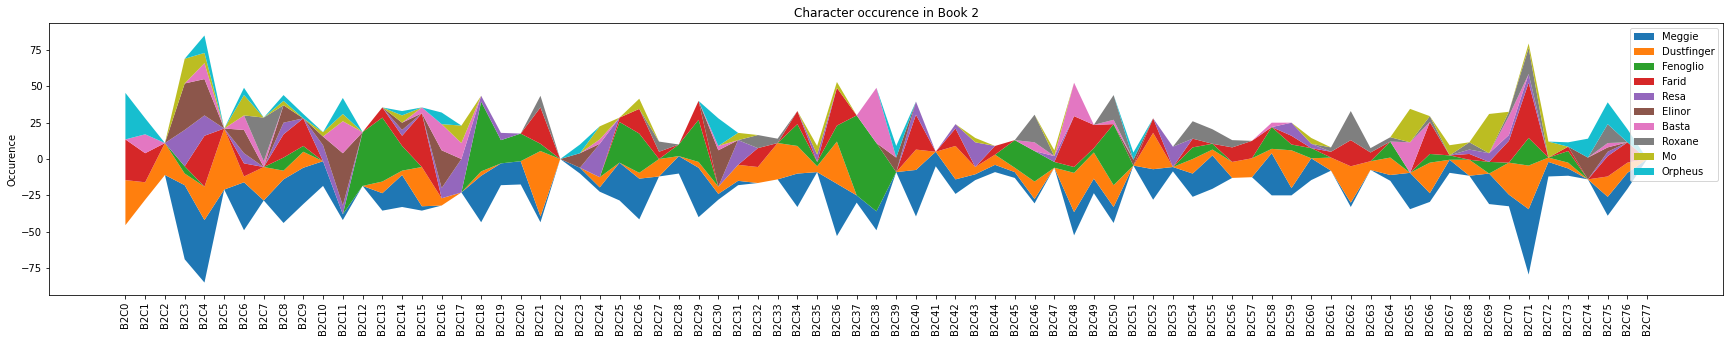

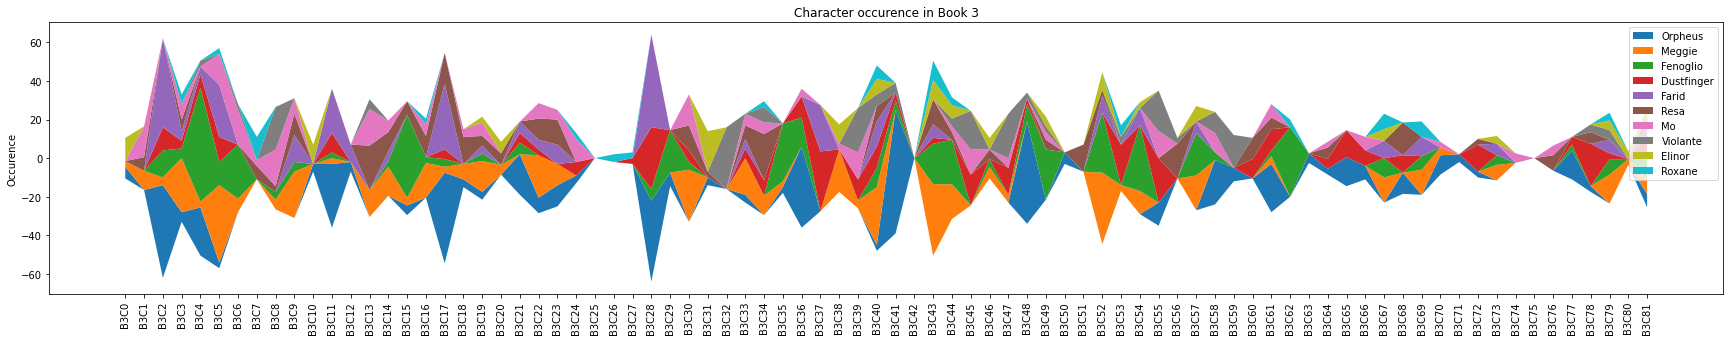

In [259]:
# Create a set of unique names found by the NER
names = set(list(itertools.chain.from_iterable(list(df['ne_count'].apply(lambda x: list(x.keys()))))))
tmp_dict = {key: val for key, val in time_name_dict.items()}
tmp = {val: sum(idx for idx in key) for val, key in tmp_dict.items()}
tmp2 = sorted(tmp_dict.items(), key = lambda ele: tmp[ele[0]], reverse=True)
tmp_dict = {key: val for key, val in tmp2}

# We take only the top 20 occuring names
names = list(tmp_dict.keys())[:20]

def plot_occurence(df_count):
    # Create an array over the 'time' in the books of occurrences of each name
    time_name_dict = {}
    for name in names:
        _tmp = list(df_count.apply(lambda x: [value for key, value in x.items() if key == name]))
        _counts = np.array([0 if len(x)==0 else x[0] for x in _tmp])
        time_name_dict[name] = _counts

    # Create a list of all book+chapter names (for the plot)
    X_1 = [f'B1C{chap}' for chap in range(len(book_1))]
    X_2 = [f'B2C{chap}' for chap in range(len(book_2))]
    X_3 = [f'B3C{chap}' for chap in range(len(book_3))]

    # Sort the sum of occurences so the most 'prominent' characters are on top
    books_Y = []
    lenlist = [
        (0, len(book_1)), 
        (len(book_1), len(book_1)+len(book_2)), 
        (len(book_1)+len(book_2), len(book_1)+len(book_2)+len(book_3))
    ]

    # Split the list in the three books for a less 'cluttered' graph
    for b, e in lenlist:
        tmp_dict = {key: val[b:e] for key, val in time_name_dict.items()}
        tmp = {val: sum(idx for idx in key) for val, key in tmp_dict.items()}
        tmp2 = sorted(tmp_dict.items(), key = lambda ele: tmp[ele[0]], reverse=True)
        tmp_dict = {key: val for key, val in tmp2}
        books_Y.append(tmp_dict)

    # Choose how many characters to show, default is 10
    CHAR_NUM = 10

    xylist = []
    for X, Y, name in [(X_1, books_Y[0], 'Book 1'), (X_2, books_Y[1], 'Book 2'), (X_3, books_Y[2], 'Book 3')]:
        fig = plt.figure(figsize=(30, 5))
        plt.stackplot(X, list(Y.values())[:CHAR_NUM], baseline='sym')
        plt.ylabel('Occurence')
        plt.xticks(rotation=90)
        plt.legend(list(Y.keys())[:CHAR_NUM])
        plt.title(f'Character occurence in {name}')
        plt.savefig(f'./images/{name}.png')
        plt.show()
        xylist.append((X, Y))


plot_occurence(df['ne_count'])

In [258]:
names

['Meggie',
 'Dustfinger',
 'Fenoglio',
 'Farid',
 'Elinor',
 'Orpheus',
 'Basta',
 'Mo',
 'Resa',
 'Capricorn',
 'Roxane',
 'Violante',
 'Silvertongue',
 'Mortola',
 'Darius',
 'Cosimo',
 'Gwin',
 'Bluejay',
 'Mortimer',
 'Piper']

### Resolve co-references to get more accurate information about character occurences and interactions

In [262]:
# Load the spacy model
nlp = spacy.load('en_core_web_sm')

# Define some weird character names that the model might have difficulty with
name_definitions = {
    'Capricorn': ['man'],
    'Dustfinger': ['man'],
    'Elinor': ['woman'],
    'Meggie': ['girl'],
    'Mo': ['man', 'father', 'Silvertongue']
}

# Create the model with the specified vocabulary and character names
coref = neuralcoref.NeuralCoref(
    nlp.vocab, 
    conv_dict=name_definitions)
nlp.add_pipe(coref, name='neuralcoref')

In [263]:
# Creates a SpaCy doc for each chapter in the dataframe
df['doc'] = df['text'].apply(nlp)

In [264]:
# Uses the previous created list of names to only resolve those co-references in the text
def resolve_coref(doc, names):
    tokens = [tok.text for tok in doc]

    for cluster in doc._.coref_clusters:
        name = cluster.main.text
        mentions = cluster.mentions

        if name in names:
            for ment in mentions:
                s = ment.start
                e = ment.end

                tokens[s:e] = [name if i == 0 else '' for i in range(e-s)]
    return ' '.join(tokens)

# Create a new column with text in which each co-reference is resolved
df['coref_resolve'] = df['doc'].apply(lambda x: resolve_coref(x, names))

In [265]:
# Counts ofccurences of a list of provided names in the provided text
def count_occurence(text, names):
    name_dict = {}
    for name in names:
        c = text.count(name)
        name_dict[name] = c
    return name_dict

# A different count now that all co-references have been resolved
df['res_ne_count'] = df['coref_resolve'].apply(lambda x: count_occurence(x, names))

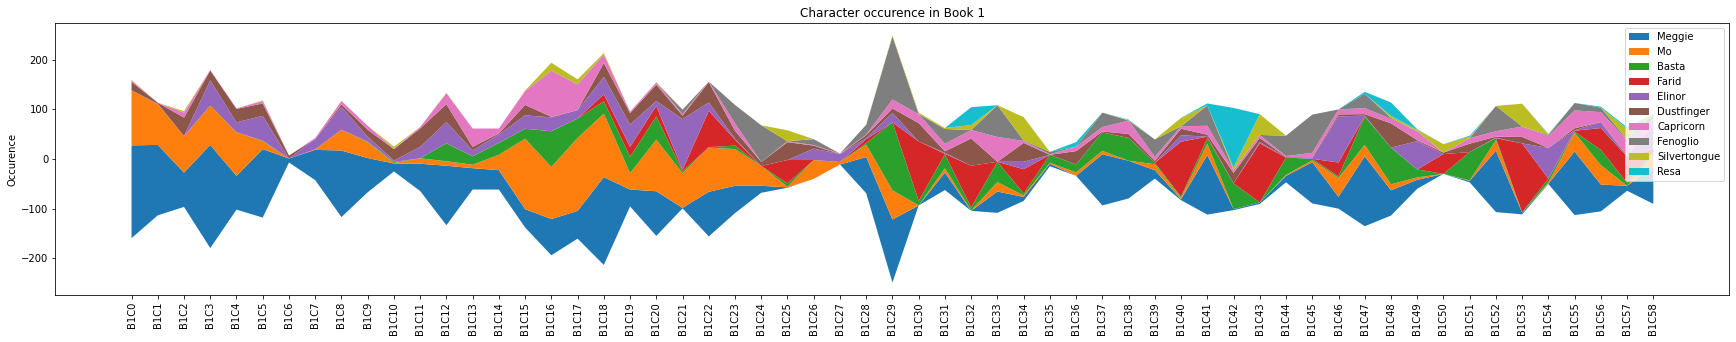

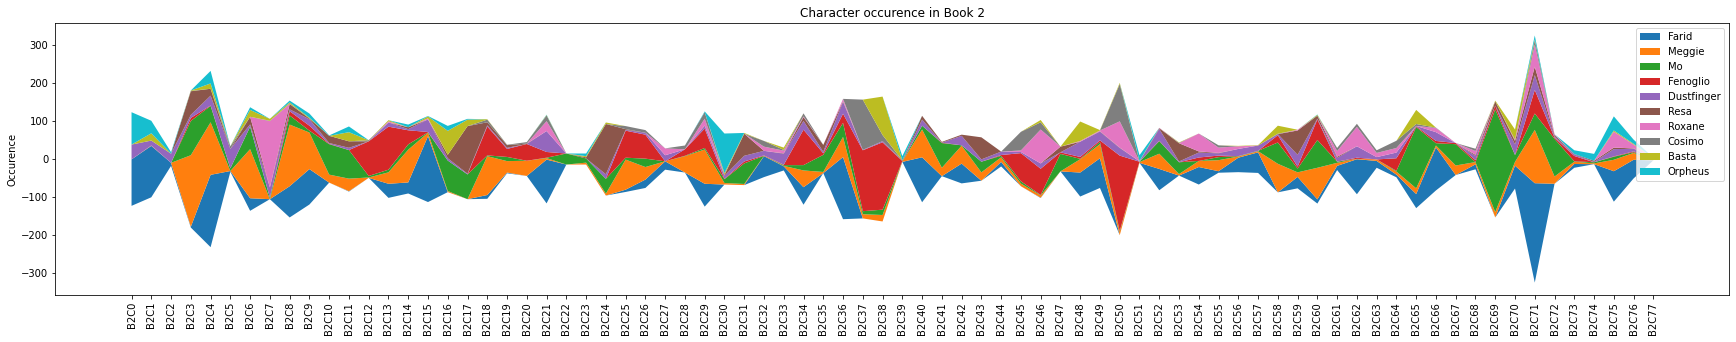

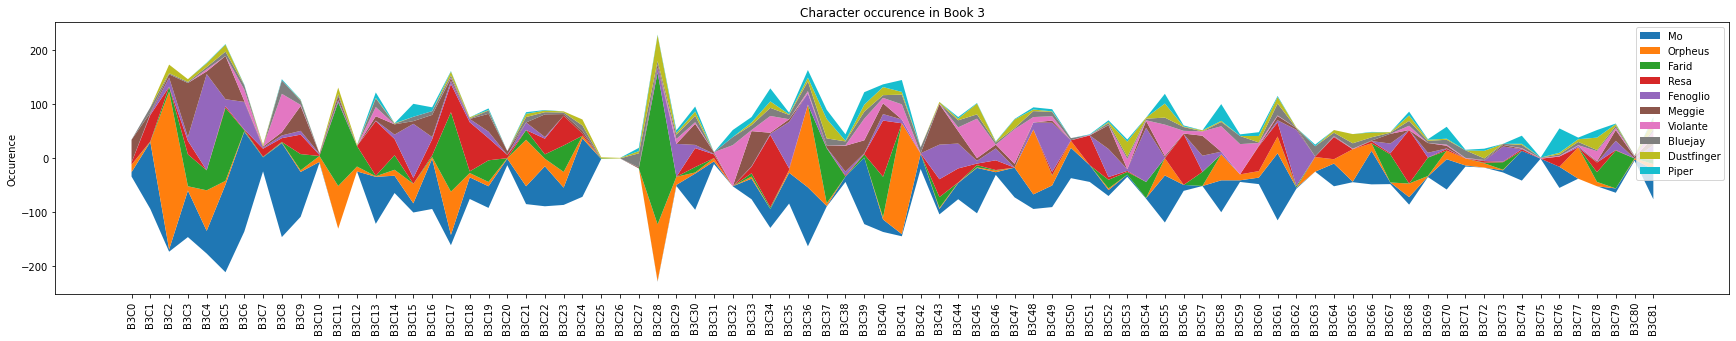

In [266]:
xylist2 = plot_occurence(df['res_ne_count'])

Let's see if the co-references that have been resolved make sense, we will take random samples from the co-references and show where and how it would be subsituted

In [ ]:
docs = list(df['doc'])

# A function to show whether a co-reference has been resolved correctly or not
all_refs = {}
for doc in docs:
    clusters = doc._.coref_clusters
    for cluster in clusters:
        if cluster.main.text not in names:
            continue
        if cluster.main.text in all_refs.keys():
            all_refs[cluster.main.text].extend(cluster.mentions)
        else:
            all_refs[cluster.main.text] = cluster.mentions

for name in all_refs.keys():
    mentions = all_refs[name]
    sample = random.randint(0, len(mentions)-1)

    test = mentions[sample]
    doc = test.doc
    if test.text == name:
        continue
    window = 20
    if window > test.start:
        window = test.start
    print(doc[test.start-window:test.start], f'[ {doc[test.start]}/{name} ]', doc[test.end:test.end+window], '\n')
    

### Error rate testing
Now we run the same method as above, but ask the user each time to say whether the coreference was correct. This way we can accumulate an error rate

In [ ]:
assesment = {'good': 0, 'bad': 0, 'neutral': 0}

In [ ]:
# This test will run untill the user stops it with input 't'
i = ''
while i != 't':
    name_sample = random.randint(0, len(all_refs.keys())-1)
    name = list(all_refs.keys())[name_sample]

    mentions = all_refs[name]
    sample = random.randint(0, len(mentions)-1)

    test = mentions[sample]
    doc = test.doc
    if test.text == name:
        continue
    window = 40
    if window > test.start:
        window = test.start
    # Prints a random sample from both the names and sentences
    print(doc[test.start-window:test.start], f'\n[ {doc[test.start]}/{name} ]\n', doc[test.end:test.end+window], '\n')

    i = input("(a/good, s/neutral, d/bad): ")  # Ask user for input

    if i.lower() == 'a':
        assesment['good'] += 1
    elif i.lower() == 's':
        assesment['neutral'] += 1
    elif i.lower() == 'd':
        assesment['bad'] += 1
    elif i.lower() == 't':
        break
    else:
        print("Wrong command, nothing is graded...")

In [ ]:
plt.bar(assesment.keys(), assesment.values())
plt.show()

### Relation mapping

In [267]:
coref_sentences = list(df['coref_resolve'].apply(nltk.sent_tokenize))

relation_dict = {}
for name1, name2 in itertools.product(names, names):
    if name1 == name2:
        continue
    if (name2, name1) in relation_dict.keys():
        continue

    combination_list = []
    for i, chap in enumerate(coref_sentences):
        chap_list = []
        for j, sent in enumerate(chap):
            if name1 in sent and name2 in sent:
                chap_list.append(1)
            else:
                chap_list.append(0)
        combination_list.append(chap_list)
    relation_dict[(name1, name2)] = combination_list

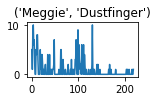

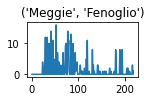

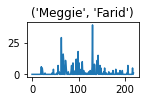

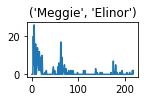

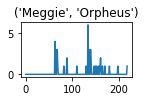

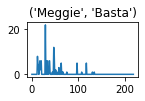

In [268]:
count = 0
for combination in relation_dict.keys():
    momeg = np.array([sum(chap) for chap in list(relation_dict[combination])])
    fig = plt.figure(figsize=(2, 1))
    plt.title(combination)
    plt.plot(momeg)
    plt.show()
    count += 1
    if count > 5:
        break

In [269]:
# Make an 'adjacency' matrix with weights for occurences
adjacency = np.zeros(shape=(len(names), len(names)))

for i, name1 in enumerate(names):
    for j, name2 in enumerate(names):
        if (name1, name2) in relation_dict.keys():
            adjacency[i, j] = sum(itertools.chain.from_iterable(relation_dict[(name1, name2)]))
            adjacency[j, i] = sum(itertools.chain.from_iterable(relation_dict[(name1, name2)]))

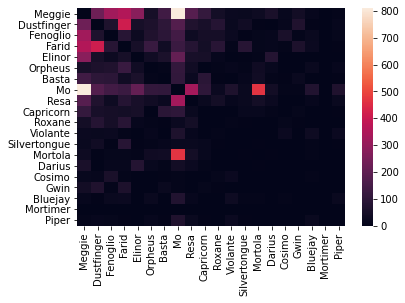

In [270]:
import seaborn as sns

sns.heatmap(
    adjacency,
    xticklabels=names,
    yticklabels=names)
plt.savefig('./images/bigheat.png')


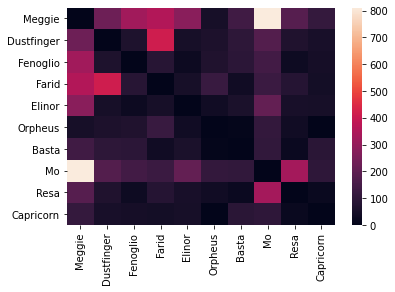

In [271]:
top_num = 10
sns.heatmap(
    adjacency[:top_num, :top_num],
    xticklabels=names[:top_num],
    yticklabels=names[:top_num])
plt.savefig('./images/smallheat.png')

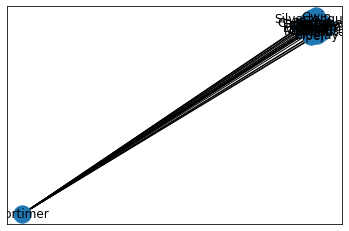

In [272]:
graph = nx.Graph()
for name in names:
    graph.add_node(name)

for i, name1 in enumerate(names):
    for j, name2 in enumerate(names):
        graph.add_weighted_edges_from([(name1, name2, adjacency[i, j])])
nx.draw_networkx(graph)

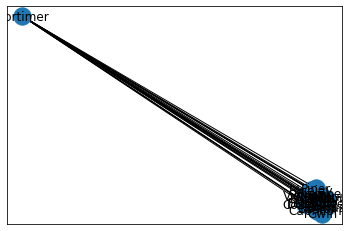

In [273]:
time_name_dict = {}
for name in names:
        _tmp = list(df['ne_count'].apply(lambda x: [value for key, value in x.items() if key == name]))
        _counts = np.array([0 if len(x)==0 else x[0] for x in _tmp])
        time_name_dict[name] = _counts

name_size = {key: sum(val) for key, val in time_name_dict.items()}

sizes = {key: {'size': val} for key, val in name_size.items()}

for name in name_size.keys():
    nx.set_node_attributes(graph, sizes)

nx.draw_networkx(graph)
nx.write_graphml(graph, 'relation_graph.graphml')

In [274]:
names

['Meggie',
 'Dustfinger',
 'Fenoglio',
 'Farid',
 'Elinor',
 'Orpheus',
 'Basta',
 'Mo',
 'Resa',
 'Capricorn',
 'Roxane',
 'Violante',
 'Silvertongue',
 'Mortola',
 'Darius',
 'Cosimo',
 'Gwin',
 'Bluejay',
 'Mortimer',
 'Piper']

In [ ]:
# Now we do the same but over each chapter to create a dynamic graph

its = [(key, key, value) for key, value in name_size.items()]
node_df = pd.DataFrame.from_records(its, columns=['Id', 'Label', 'Size'])
print(node_df.head())
node_df.to_csv('node_test.csv', index=False)

In [ ]:
edges = []
for combination in relation_dict.keys():
    adjacency = np.zeros(shape=(len(relation_dict.keys()), len(relation_dict.keys())))
    chap_list = np.array([sum(chap) for chap in list(relation_dict[combination])])
    edges.extend([(combination[0], combination[1], chap, f'<[{i},{i}]>') for i, chap in enumerate(chap_list)])

edge_df = pd.DataFrame.from_records(edges, columns=['Source', 'Target', 'Weight', r'TimeSet'])
edge_df.to_csv('edge_test.csv', index=False)

These `csv` files can be read by the application 'Gephi' which is able to both display and arange the nodes and edges, as well as showing the edge weights over time

## Location extraction

In [ ]:
locations = [
    ['castle', 'lake'],
    ['castle', 'ombra'],
    ['spelt', 'mill'],
    ['wayless', 'wood'],
    ['argenta'],
    ['fortress']
]

for tokenlist in itertools.chain.from_iterable(list(df['tokens'])):
    loc_bool = [[True if loc in tokenlist else False for loc in location] for location in locations]
    for location in loc_bool:
        if True in location:
            print(tokenlist)


### Dependency mapping

Next step is to use the characters names and locations to show changes of scenery for each character

In [ ]:
import networkx as nx

def make_graph(doc):
    edges = []
    for token in doc:
        for child in token.children:
            edges.append(('{0}'.format(token.lower_),
                        '{0}'.format(child.lower_)))

    graph = nx.Graph(edges)
    return graph

df['graphs'] = df['doc'].apply(make_graph)

In [ ]:
fig = plt.figure(figsize=(15, 9))
nx.draw_networkx(df['graphs'].iloc[0])
plt.show()

In [ ]:
# Get the length and path

for i, graph in enumerate(list(df['graphs'])):
    entity1 = 'Meggie'.lower()
    entity2 = 'castle'.lower()
    try:
        print(nx.shortest_path_length(graph, source=entity1, target=entity2))
        print(i, nx.shortest_path(graph, source=entity1, target=entity2))

        path = nx.shortest_path(graph, source=entity1, target=entity2)
        for sent in df['sentences'].iloc[i]:
            path_sent = True
            for word in path:
                if word not in sent.lower():
                    path_sent = False
            if path_sent:
                print(sent)
    except nx.NodeNotFound:
        pass

